# Wikipedia - Image/Caption Matching
## Retrieve captions based on images


<br>

### Description

A picture is worth a thousand words, yet sometimes a few will do. We all rely on online images for knowledge sharing, learning, and understanding. Even the largest websites are missing visual content and metadata to pair with their images. Captions and “alt text” increase accessibility and enable better search. The majority of images on Wikipedia articles, for example, don't have any written context connected to the image. Open models could help anyone improve accessibility and learning for all.

Current solutions rely on simple methods based on translations or page interlinks, which have limited coverage. Even the most advanced computer vision image captioning isn't suitable for images with complex semantics.


### Data

The objective of this competition is to predict the target caption_title_and_reference_description given information about an images. The targets for this competition are in multiple languages.

#### Files
* train-{0000x}-of-00005.tsv - the training data (tab delimited)
* test.tsv - the test data; the objective is to predict the target caption_title_and_reference_description for each row id
* sample_submission.csv - a sample submission file in the correct format; note that multiple predictions (up to 5) are allowed for each id in the test data.
* image_data_test/
* * image_pixels/test_image_pixels_part-{0000x}.csv.gz
* * * image_url: url to the original image file, e.g. https://upload.wikimedia.org/wikipedia/commons/e/ec/Hovden.jpg
* * * b64_bytes: base64 encoded bytes of the image file at a 300px resolution
* * * metadata_url: url to the commons page of the image, e.g. https://commons.wikimedia.org/wiki/File:Hovden.jpg
* * resnet_embeddings/test_resnet_embeddings_part-{0000x}.csv.gz
* * * image_url: url to the original image file, e.g. https://upload.wikimedia.org/wikipedia/commons/e/ec/Hovden.jpg
* * * embedding: a comma separated list of 2048 float values
* image_data_train - Due to the size of the training image data (~275 Gb), it is hosted separately and can be found here. Note that not all of the training observations have corresponding image data.

<code> kaggle competitions download -c wikipedia-image-caption </code>

### Submission

Submissions will be evaluated using NDCG@5 (Normalized Discounted Cumulative Gain).

The submission should be a list of id,caption_title_and_reference_description pairs ranked from top to bottom according to their relevance (i.e., the top id is the most relevant caption_title_and_reference_description), with up to 5 predictions per id. Each line should be a single id,caption_title_and_reference_description pair.


### Prizes

The top three winning teams will receive Wikipedia-branded merchandise

In [1]:
import os
import requests

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import PIL.Image

from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.listdir('../input/wikipedia-image-caption/')

['sample_submission.csv',
 'test.tsv',
 'train-00000-of-00005.tsv',
 'train-00003-of-00005.tsv',
 'train-00002-of-00005.tsv',
 'train-00001-of-00005.tsv',
 'image_data_test',
 'train-00004-of-00005.tsv']

In [3]:
df = pd.read_csv('../input/wikipedia-image-caption/image_data_test/image_pixels/test_image_pixels_part-00000.csv', sep='\t', names=['image_url', 'b64_bytes', 'metadata_url'])
df

,image_url,b64_bytes,metadata_url
0,http://upload.wikimedia.org/wikipedia/commons/...,/9j/4AAQSkZJRgABAQEASABIAAD//gBbRmlsZSBzb3VyY2...,http://commons.wikimedia.org/wiki/File:Dodge_C...
1,https://upload.wikimedia.org/wikipedia/commons...,/9j/4QB+RXhpZgAATU0AKgAAAAgABgEOAAIAAAAKAAAAVg...,http://commons.wikimedia.org/wiki/File:Granada...
2,https://upload.wikimedia.org/wikipedia/commons...,/9j/4gO4SUNDX1BST0ZJTEUAAQEAAAOoS0NNUwIQAABtbn...,http://commons.wikimedia.org/wiki/File:Demolit...
3,https://upload.wikimedia.org/wikipedia/commons...,/9j/4gUoSUNDX1BST0ZJTEUAAQEAAAUYYXBwbAIgAABzY2...,http://commons.wikimedia.org/wiki/File:311_Sou...
4,https://upload.wikimedia.org/wikipedia/commons...,/9j/7gAOQWRvYmUAZAAAAAAC/9sAQwAEAwMEAwMEBAMEBQ...,http://commons.wikimedia.org/wiki/File:Benny_a...
...,...,...,...
8947,https://upload.wikimedia.org/wikipedia/commons...,/9j/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw...,http://commons.wikimedia.org/wiki/File:Dinosau...
8948,https://upload.wikimedia.org/wikipedia/commons...,/9j/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw...,http://commons.wikimedia.org/wiki/File:Gorbach...
8949,https://upload.wikimedia.org/wikipedia/commons...,/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAYEBQYFBAYGBQ...,http://commons.wikimedia.org/wiki/File:LamarCo...
8950,https://upload.wikimedia.org/wikipedia/commons...,/9j/4QB2RXhpZgAATU0AKgAAAAgABQEaAAUAAAABAAAASg...,http://commons.wikimedia.org/wiki/File:Foley_W...


In [4]:
df.describe()

,image_url,b64_bytes,metadata_url
count,8952,8952,8952
unique,8952,8950,8950
top,http://upload.wikimedia.org/wikipedia/commons/...,/9j/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw...,http://commons.wikimedia.org/wiki/File:Marcel_...
freq,1,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8952 entries, 0 to 8951
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_url     8952 non-null   object
 1   b64_bytes     8952 non-null   object
 2   metadata_url  8952 non-null   object
dtypes: object(3)
memory usage: 209.9+ KB


In [6]:
sub = pd.read_csv('../input/wikipedia-image-caption/sample_submission.csv')
sub

,id,caption_title_and_reference_description
0,0,diam in ve ligula a sapien mattis a a
1,0,nisi ut eu
2,0,urna ad a duis a ligula dis ve
3,0,eros eu a vel congue ac et justo sapien
4,0,diam mi a mi nec a leo sed ornare magna mus se...
...,...,...
461825,92365,arcu et a a leo odio a a risus leo per
461826,92365,duis ve in ve ut
461827,92365,duis ac a leo a dis
461828,92365,eget ac


In [7]:
sub.shape

(461830, 2)

In [8]:
test_file = pd.read_csv('../input/wikipedia-image-caption/test.tsv', sep='\t')
test_file

,id,language,page_url,image_url
0,0,es,https://es.wikipedia.org/wiki/G%C3%A0idhealtachd,https://upload.wikimedia.org/wikipedia/commons...
1,1,fi,https://fi.wikipedia.org/wiki/Thermop%C3%BDles,https://upload.wikimedia.org/wikipedia/commons...
2,2,en,https://en.wikipedia.org/wiki/National_Registe...,https://upload.wikimedia.org/wikipedia/commons...
3,3,el,https://el.wikipedia.org/wiki/%CE%9D%CE%B5%CF%...,https://upload.wikimedia.org/wikipedia/commons...
4,4,zh-TW,https://zh.wikipedia.org/zh-tw/%E4%BC%A6%E4%BD...,https://upload.wikimedia.org/wikipedia/commons...
...,...,...,...,...
92361,92361,af,https://af.wikipedia.org/wiki/Alster,https://upload.wikimedia.org/wikipedia/commons...
92362,92362,eo,https://eo.wikipedia.org/wiki/Stavoren,https://upload.wikimedia.org/wikipedia/commons...
92363,92363,cs,https://cs.wikipedia.org/wiki/Seznam_objekt%C5...,https://upload.wikimedia.org/wikipedia/commons...
92364,92364,pt,https://pt.wikipedia.org/wiki/Winchester_Repea...,https://upload.wikimedia.org/wikipedia/commons...


In [12]:
fig = px.pie(test_file, values=test_file['language'].value_counts().values, names=test_file['language'].value_counts().index,
            title='Languages Distribution', color_discrete_sequence=px.colors.sequential.RdBu, hole=.3
            )
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

In [13]:
import urllib

In [14]:
def get_links(df, num):
    return df.image_url[:num].values

links = get_links(df, 10)


def load_images(links):
    images = []
    
    for link in links:
        URL = link
        try:

            with urllib.request.urlopen(URL) as url:
                with open('./temp.jpg', 'wb') as f:
                    f.write(url.read())

            img = PIL.Image.open('./temp.jpg')
            img = np.asarray(img)
            images.append(img)
        except:
            continue
    return images

def display_images(images, title=None): 
    f, ax = plt.subplots(2,5, figsize=(18,12))
    if title:
        f.suptitle(title, fontsize = 30)

    for i, image_id in enumerate(images):
        ax[i//5, i%5].imshow(image_id) 
   
        ax[i//5, i%5].axis('off')

    plt.show() 

In [15]:
images = load_images(links)

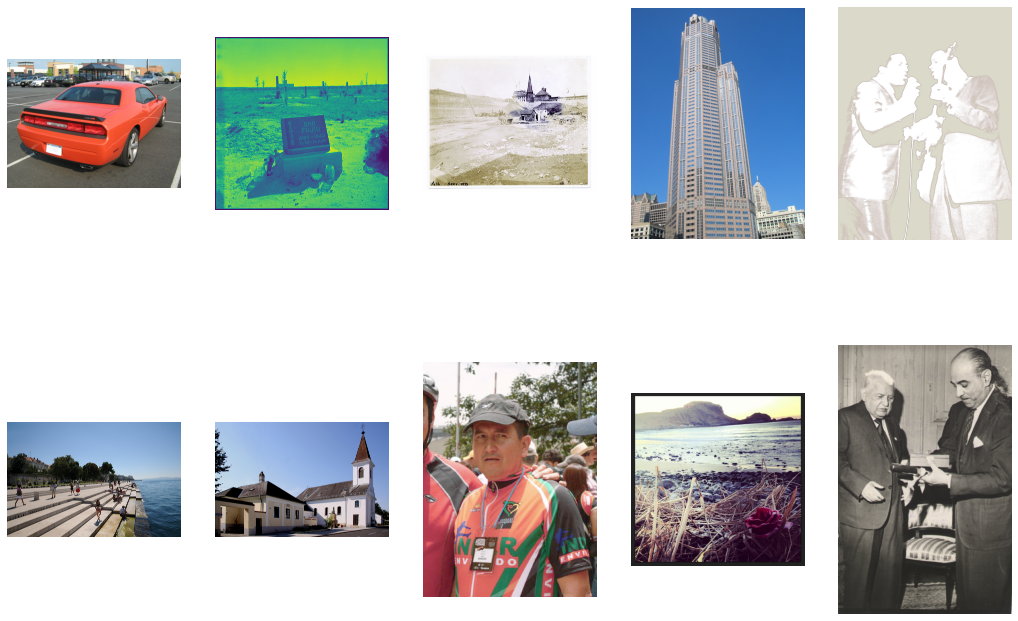

In [16]:
display_images(images)

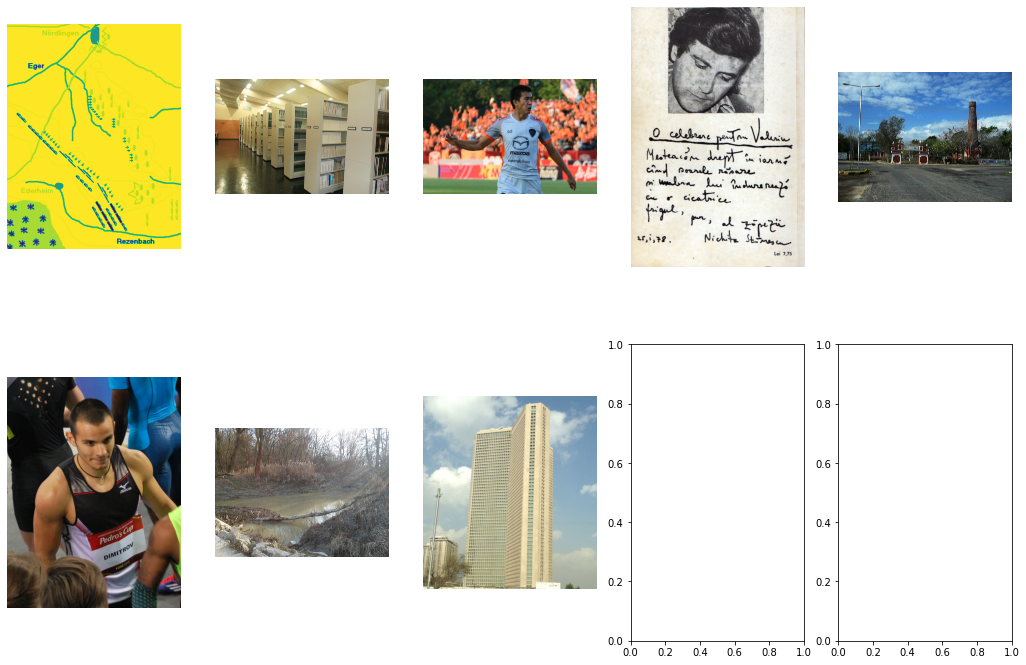

In [17]:
links = df.image_url[20:30].values
images = load_images(links)
display_images(images)

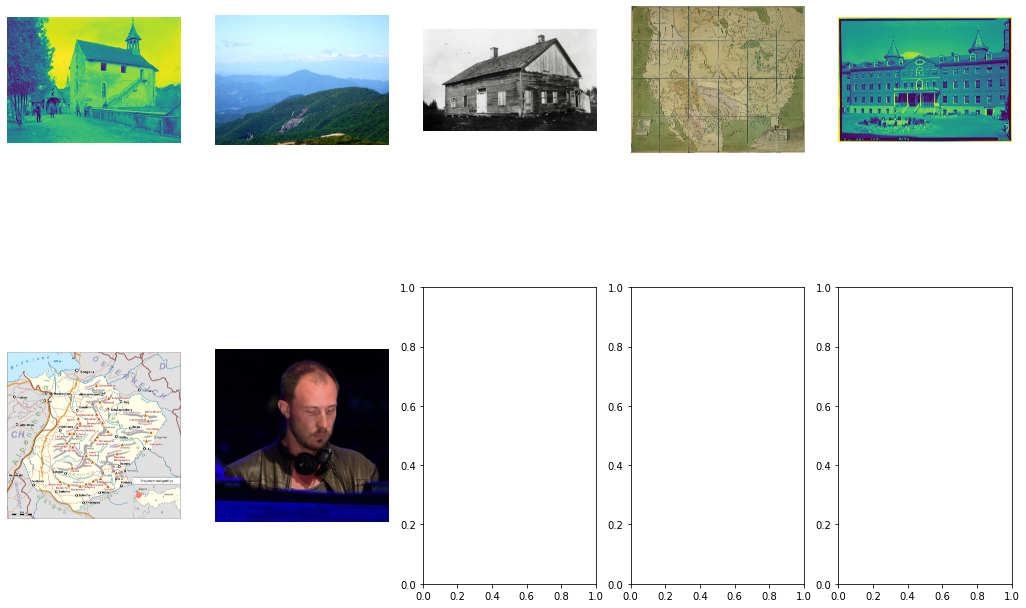

In [18]:
links = df.image_url[30:40].values
images = load_images(links)
display_images(images)

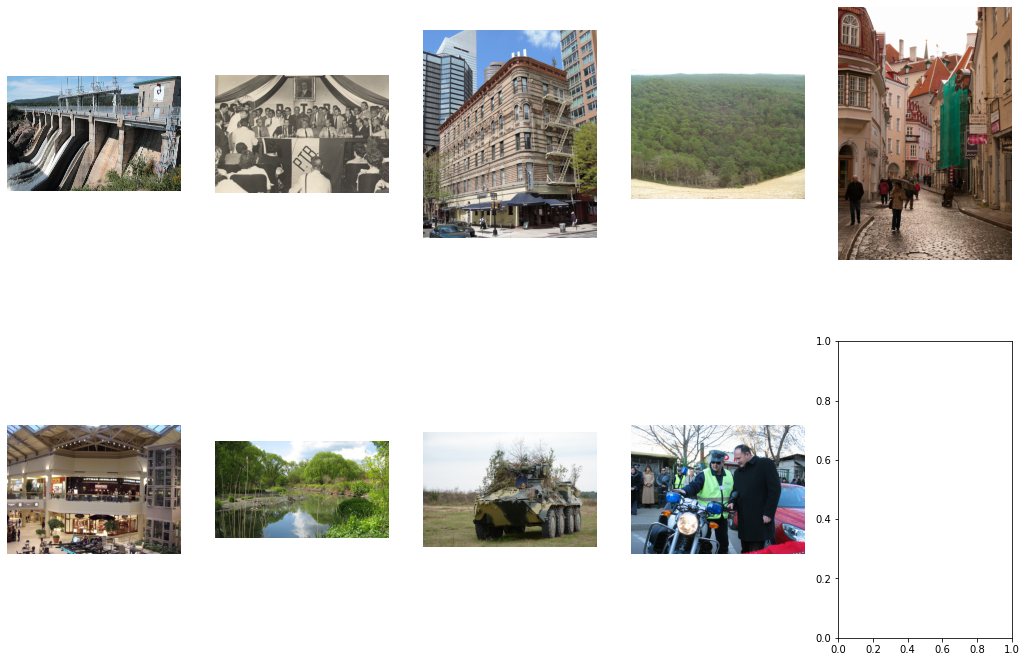

In [19]:
links = df.image_url[40:50].values
images = load_images(links)
display_images(images)

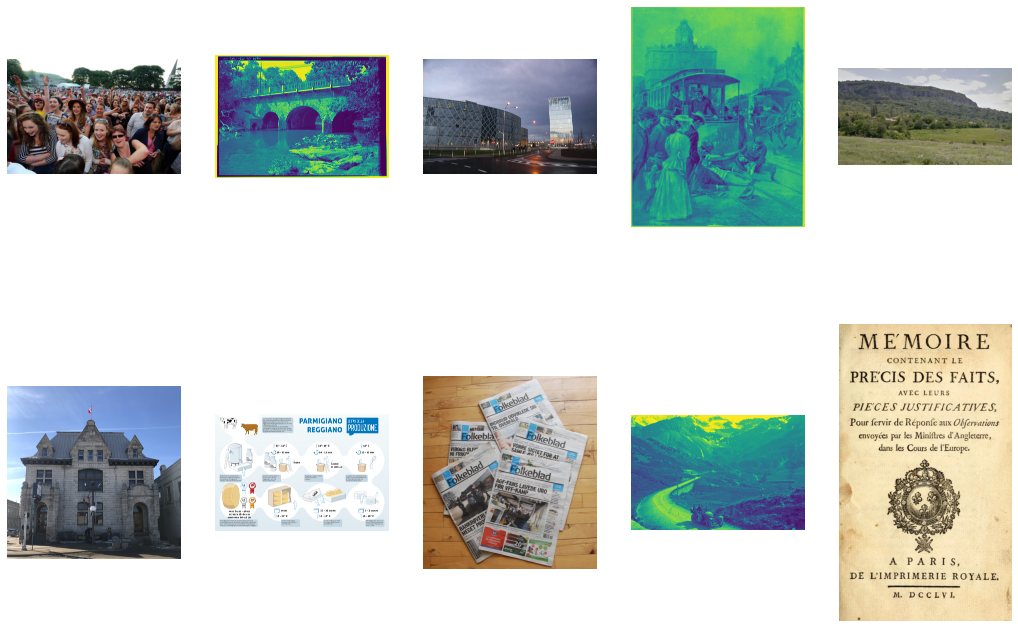

In [20]:
links = df.image_url[50:60].values
images = load_images(links)
display_images(images)

#### Some images is not downloading and temp.jpg is empty

### Work in progress...